# Modelling Notebook

$\beta_t = \beta_0  \times C(T) \times S(T) \times H  \\
H=(1 - m\times \frac{I^3} {k^3 + I^3}) \\
  \frac{dS}{dt} = \nu  N - \frac{\beta_t  I  S} {N} - \mu S\\
  \frac{dE}{dt}=  \frac{\beta_t  I  S} {N} - (\sigma + \mu) E\\
  \frac{dI}{dt} = \sigma  E - (\alpha + \mu + \gamma) I\\
  \frac{dR}{dt} = \gamma I - \mu R $  
C and S are functions of climate (starting with temperature)
climate is a function of time 

T(t)
Humidity will also probably be included similarly to temperature 


## C -contact duration

$s=\frac{c_u-m_T}{1.96} \\
N_D(T)=  \frac{1}{\sqrt{2\pi}\times s} \times e^\frac{-(T-m_T)^2}{2 s^2}\\ $  
scaled to maximum duration:   
$C(T)= N_D(T) \times \sqrt{2\pi} \times s \times m_d$ units:time   
scaled to one:    
$C(T)= N_D(T) \times \sqrt{2\pi} \times s $ units:dimensionless  
s is from $CI=\mu \pm z s$, then rearrange.   
N_D is just the normal distribution.  
C(T) is the normal distribution scaled. This works because when $T=m_T$ then $N_D=\frac{1}{\sqrt{2\pi}s}$   


$m_T$ and $m_d$ are the temperature and duration of contact at the maximum duration. $c_l$ and $c_u$ is the interval at which 95\%  of the duration is likely to occur. The standard deviation $s$ is the calculated such that 95\% of the area falls between $c_l$ and $c_u$.  $N_D$ is the normal distribution with standard distribution $s$ and mean $m_T$. $T$ is the temperature.  

In [1]:
duration_scaled_1 <- function(m , c, T_range){
    T = seq(T_range[1],T_range[2],length.out = 10000)
    c_u = c[2]
    m_T = m[1]
    m_d = m[2]
    s = (c_u- m_T) / 1.96
    N_D =  (1 / (sqrt(2 * pi) * s)) *  exp( ( - ( T - m_T ) ^2 ) / (2 * s^2))
    d = N_D * sqrt(2 * pi) * s 
    #Multiply by a factor such that the max of d is 1
    #d=N_D*19/mean(N_D)

    #plot(T,N_D,type="s")
    plot(T,d,type="s")
}

duration_scaled_max <- function(m , c, T_range){
    T = seq(T_range[1],T_range[2],length.out = 10000)
    c_u = c[2]
    m_T = m[1]
    m_d = m[2]
    s = (c_u- m_T) / 1.96
    N_D =  (1 / (sqrt(2 * pi) * s)) *  exp( ( - ( T - m_T ) ^2 ) / (2 * s^2))
    d = N_D * sqrt(2 * pi) * s * m_d
    #Multiply by a factor such that the max of d is 1
    #d=N_D*19/mean(N_D)

    #plot(T,N_D,type="s")
    plot(T,d,type="s")
}


Initial ideas for estimating parameters:
 - use of polymod dataset
     - unfortunately in discrete categories so estimate midpoint of categories. For each participant, multiply number in each category by the midpoint and sum each compartment together. Then find the mean of this.
     - use the mean to predict the maximum (double??)
     - find minimum duration, and assign to lowest temperature 
     - n.b  in this dataset >24 hours is common because it is done by contacts.
     - considering limiting the type of interaction e.g. only physical or only leisure
 - another data source
     - google maps data (LOOK INTO WHAT IS AVAILABLE.https://ai.googleblog.com/2019/11/new-insights-into-human-mobility-with.html,https://www.google.com/covid19/mobility/,https://www.nature.com/articles/s41467-019-12809-y#MOESM1). intial thoughts is that it may be possible to find movement over time (weekly) but very complicated.  
     
     
Issue with current idea is not based on any actual info!

In [2]:
library(socialmixr)
data("polymod")
data <- polymod$contacts
contact_table <- table(data$part_id, data$duration_multi)
#seems to be shifted 
del <- as.numeric(names(which(contact_table[, 1] > 0)))
data <- data[which(data$part_id != del), ]
contact_table <- table(data$part_id, data$duration_multi)
con <- as.matrix(contact_table)
midpoints <- c(2.5, 10, 15 + (60 - 45) / 2, 150, 4 * 60)

time <- midpoints * con / 60
timebyrow <- apply(time, 1, sum)
#timebyrow
meancont<-mean(timebyrow)
maxcont<-meancont+2*sqrt(var(timebyrow))
#max(timebyrow)
#min(timebyrow)


Attaching package: ‘socialmixr’

The following object is masked from ‘package:utils’:

    cite



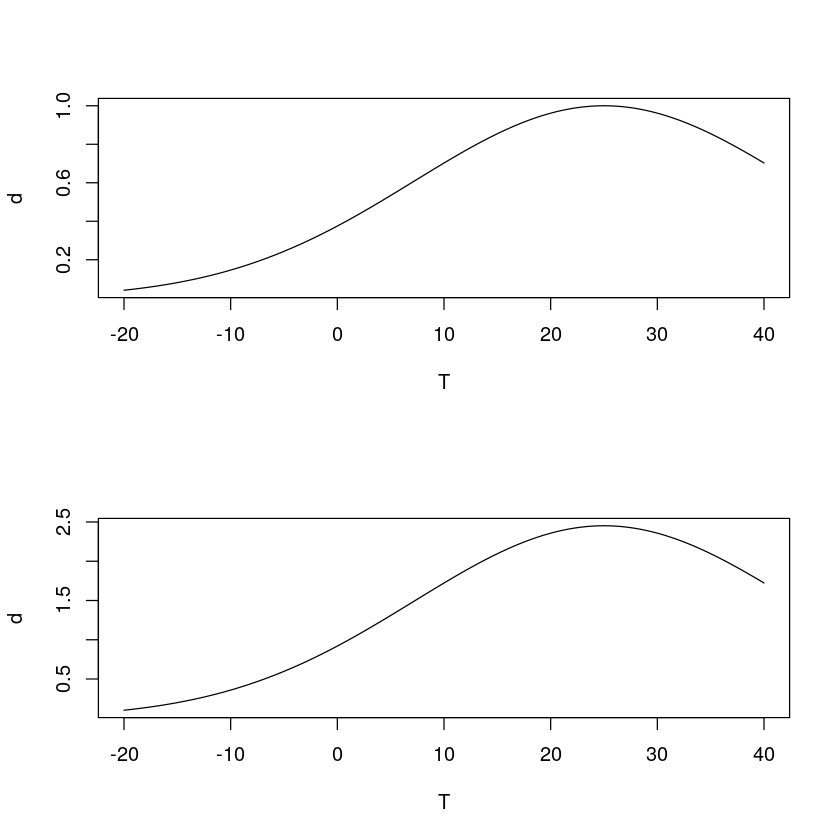

In [3]:
par(mfrow = c(2,1))

duration_scaled_1(m = c(25,maxcont/24) , c=c(-20,60), T_range=c(-20,40))
duration_scaled_max(m = c(25,maxcont/24) , c=c(-20,60), T_range=c(-20,40))

#/24 so in terms of days

## S - survivability of virus


Equation for exponential virus decay:  
$V=V_0 \times e^{qt} $   
where V_0 is the initial virus density and q is the rate of decay.   
q can be calculated from substituting V_0 and the coordinates at another time into the equation. 
(alternatively:$V= q^t \times V_0$)
This would be more accurate if you included that q will vary with time, but here just getting rough idea to understand.  
scaled so positive:  
$S(T)= f(T) - min(f(T))$  - units? 1/time  
scaled between 0 and 1:  
$S(T)= (f(T) - min(f(T)))/(max(f(T)-min(f(T))$  -units?- dimensionless?  

where f(T) is bassed on a  quadratic equation made from fitting a quadratic equation to  the decay rate at different temperatures

In [4]:
findq<-function(V_0,timepoint){
    x<-seq(0,10,length.out = 10000)
    q<-log(timepoint[2]/V_0)/timepoint[1]
    V<-V_0 * exp(q*x)
  #  plot(x,V,type="s")
    return(q)
    }

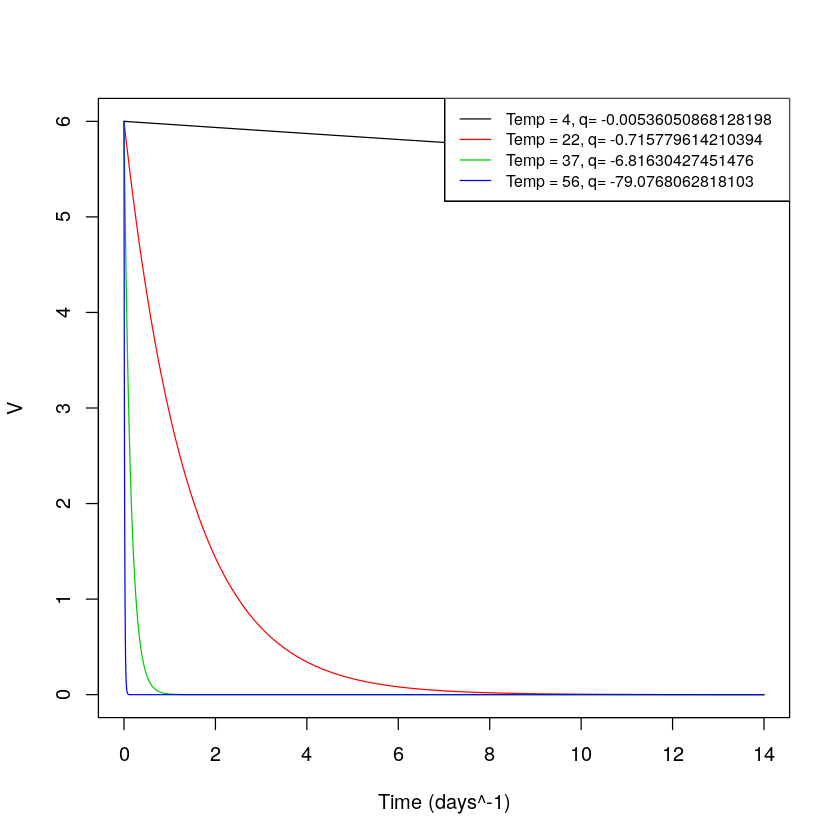

In [5]:
x<-c(4,22,37,56,70)
#until q undetectable for all
#y<-c(findq(6.51,c(14*24*60-30,6.04)),findq(6.51,c(7*3*60,3.48)),findq(6.57,c(1*3*60-30,3.23)),findq(6.65,c(10,3.84)),findq(5.34,c(5,0)))
y<-c(findq(6.51,c((14*24*60-30)/(24*60),6.04)),findq(6.51,c((7*3*60)/(24*60),3.48)),findq(6.57,c((1*3*60-30)/(24*60),3.23)),findq(6.65,c(10/(24*60),3.84)),findq(5.34,c(5/(24*60),0)))

t=seq(0,14,length.out = 100000)
V_0=6

#this is just an illustration
plot(1, type="n", xlab="Time (days^-1)", ylab="V", xlim=c(0, 14), ylim=c(0, 6))
for(i in 1:(length(y)-1)){
    V<-V_0 * exp(y[i]*t)
    lines(t,V,type="s",col=i)
   legend("topright", legend = c(paste0("Temp = ",x[1],", q= ", y[1]),paste0("Temp = ",x[2],", q= ", y[2]),paste0("Temp = ",x[3],", q= ", y[3]),paste0("Temp = ",x[4],", q= ", y[4])), col = c(1, 2,3,4),lty = 1,    cex = 0.8)

}

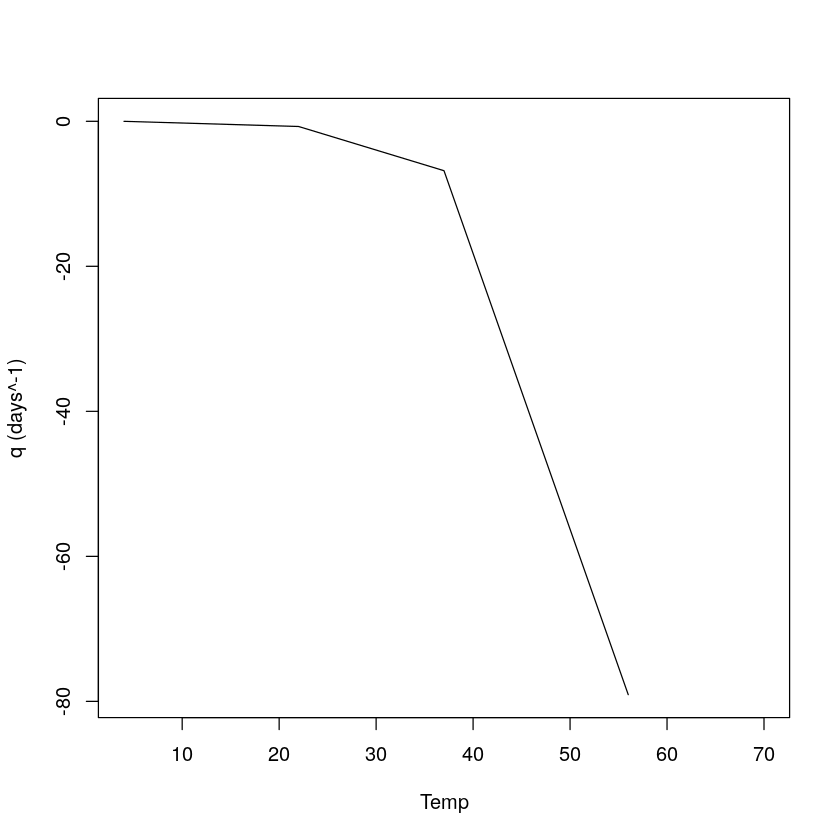

In [6]:

x<-c(4,22,37,56,70)
#until q undetectable for all
#y<-c(findq(6.51,c(14*24*60-30,6.04)),findq(6.51,c(7*3*60,3.48)),findq(6.57,c(1*3*60-30,3.23)),findq(6.65,c(10,3.84)),findq(5.34,c(5,0)))

y<-c(findq(6.51,c((14*24*60-30)/(24*60),6.04)),findq(6.51,c((7*3*60)/(24*60),3.48)),findq(6.57,c((1*3*60-30)/(24*60),3.23)),findq(6.65,c(10/(24*60),3.84)),findq(5.34,c(5/(24*60),0)))

plot(x,y,type="l",xlab="Temp",ylab="q (days^-1)")

q(T) is a quadratic equation fit to the growth rate at different temperatures using the vertex and one other point and temperature limits. As this results in negative numbers, it needs to be scaled to maintain the shape of the curve while removing negative values.

### manual quadratic (i.e. not fitting a linear model)
initial, all positive and scaled

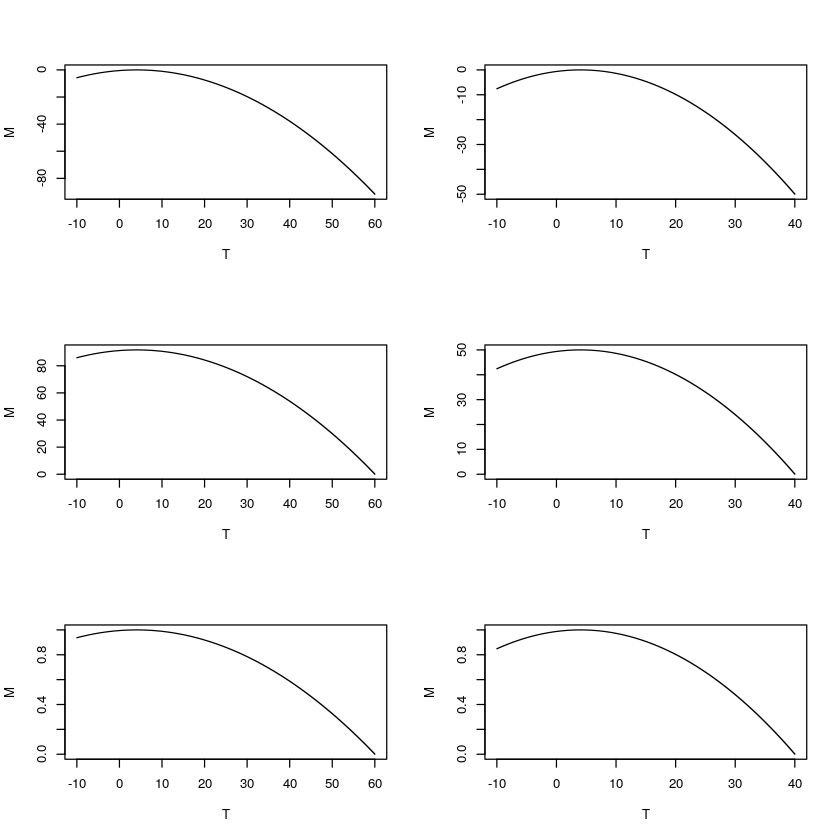

In [7]:
par(mfrow = c(3, 2))


make_quadratic_manually<- function(vertex , point , T_range){
   #vertex is the maxima or minima, point is another point on the curve
        T = seq(T_range[1], T_range[2] , length.out = 1000)
        M =  ( ( point[2] - vertex[2]) / (point[1] - vertex[1]) ^2) * (T-vertex[1])^2 + vertex[2]
       #for parameters of quadratic equation
        #a = ( ( point[2] - vertex[2]) / (point[1] - vertex[1]) ^2)
       # b = ( ( point[2] - vertex[2]) / (point[1] - vertex[1]) ^2) * -2 * vertex[1]  
        #c = ( ( point[2] - vertex[2]) / (point[1] - vertex[1]) ^2) * vertex[1]^2 + vertex[2]
    plot(T,M,type="s")
    #return(c(a,b,c))
}

#from above
x<-c(4,22,37,56,70)

y<-c(findq(6.51,c((14*24*60-30)/(24*60),6.04)),findq(6.51,c((7*3*60)/(24*60),3.48)),findq(6.57,c((1*3*60-30)/(24*60),3.23)),findq(6.65,c(10/(24*60),3.84)),findq(5.34,c(5/(24*60),0)))
make_quadratic_manually(vertex= c(x[1],y[1]),point= c(x[4],y[4]),T_range=c(-10,60))

make_quadratic_manually(vertex=c(4,0),T_range=c(-10,40),point=c(40,-50))


make_quadratic_manually_positive<- function(vertex , point , T_range){
   #vertex is the maxima or minima, point is another point on the curve
        T = seq(T_range[1], T_range[2] , length.out = 1000)
        M =  ( ( point[2] - vertex[2]) / (point[1] - vertex[1]) ^2) * (T-vertex[1])^2 + vertex[2]
        M = M - min(M)
       #for parameters of quadratic equation
        #a = ( ( point[2] - vertex[2]) / (point[1] - vertex[1]) ^2)
       # b = ( ( point[2] - vertex[2]) / (point[1] - vertex[1]) ^2) * -2 * vertex[1]  
        #c = ( ( point[2] - vertex[2]) / (point[1] - vertex[1]) ^2) * vertex[1]^2 + vertex[2]
    plot(T,M,type="s")
    #return(c(a,b,c))
}

#from above
x<-c(4,22,37,56,70)

y<-c(findq(6.51,c((14*24*60-30)/(24*60),6.04)),findq(6.51,c((7*3*60)/(24*60),3.48)),findq(6.57,c((1*3*60-30)/(24*60),3.23)),findq(6.65,c(10/(24*60),3.84)),findq(5.34,c(5/(24*60),0)))
make_quadratic_manually_positive(vertex= c(x[1],y[1]),point= c(x[4],y[4]),T_range=c(-10,60))

make_quadratic_manually_positive(vertex=c(4,0),T_range=c(-10,40),point=c(40,-50))



make_quadratic_manually_scaled<- function(vertex , point , T_range){
   #vertex is the maxima or minima, point is another point on the curve
        T = seq(T_range[1], T_range[2] , length.out = 1000)
        M =  ( ( point[2] - vertex[2]) / (point[1] - vertex[1]) ^2) * (T-vertex[1])^2 + vertex[2]
        M = (M - min(M))/(max(M)-min(M))
       #for parameters of quadratic equation
        #a = ( ( point[2] - vertex[2]) / (point[1] - vertex[1]) ^2)
       # b = ( ( point[2] - vertex[2]) / (point[1] - vertex[1]) ^2) * -2 * vertex[1]  
        #c = ( ( point[2] - vertex[2]) / (point[1] - vertex[1]) ^2) * vertex[1]^2 + vertex[2]
    plot(T,M,type="s")
    #return(c(a,b,c))
}

#from above
x<-c(4,22,37,56,70)
y<-c(findq(6.51,c((14*24*60-30)/(24*60),6.04)),findq(6.51,c((7*3*60)/(24*60),3.48)),findq(6.57,c((1*3*60-30)/(24*60),3.23)),findq(6.65,c(10/(24*60),3.84)),findq(5.34,c(5/(24*60),0)))
make_quadratic_manually_scaled(vertex= c(x[1],y[1]),point= c(x[4],y[4]),T_range=c(-10,60))

make_quadratic_manually_scaled(vertex=c(4,0),T_range=c(-10,40),point=c(40,-50))





## H - containment

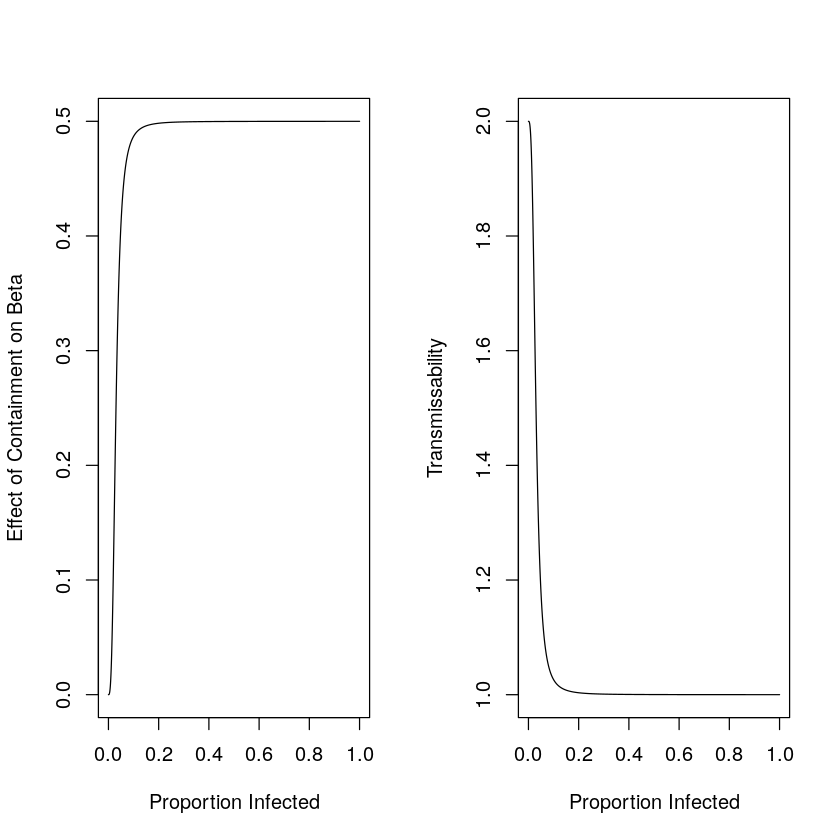

In [8]:

par(mfrow = c(1,2))

I<-seq(0,1,length.out = 10000)
d<-(0.5*I^3/(0.03^3+I^3))
plot(I,d,"s",ylab="Effect of Containment on Beta",xlab="Proportion Infected")
beta<-2*(1-0.5*(I^3/(0.03^3+I^3)))
plot(I,beta,"s",ylab="Transmissability",xlab="Proportion Infected")

## Plots

In [22]:
par(mfrow = c(2, 1))


#R0 and S functions
make_quadratic_manually_scaled <- function(vertex , point , T_range) {
  #vertex is the maxima or minima, point is another point on the curve
  T = seq(T_range[1], T_range[2] , length.out = 1000)
  M =  ((point[2] - vertex[2]) / (point[1] - vertex[1]) ^ 2) * (T - vertex[1]) ^
    2 + vertex[2]
  
  
  a = ((point[2] - vertex[2]) / (point[1] - vertex[1]) ^ 2) / (max(M) -
                                                                 min(M))
  b = (((point[2] - vertex[2]) / (point[1] - vertex[1]) ^ 2) * -2 * vertex[1]) /
    (max(M) - min(M))
  c = (((point[2] - vertex[2]) / (point[1] - vertex[1]) ^ 2) * vertex[1] ^
         2 + vertex[2] - min(M)) / (max(M) - min(M))
  M = (M - min(M)) / (max(M) - min(M))
  #plot(T,M,type="s")
  return(c(a, b, c))
}


duration_scaled_1 <- function(m , c, T_range) {
  T = seq(T_range[1], T_range[2], length.out = 10000)
  c_u = c[2]
  m_T = m[1]
  m_d = m[2]
  s = (c_u - m_T) / 1.96
  N_D =  (1 / (sqrt(2 * pi) * s)) *  exp((-(T - m_T) ^ 2) / (2 * s ^ 2))
  d = N_D * sqrt(2 * pi) * s
  #Multiply by a factor such that the max of d is 1
  #plot(T,d)
  return(c(m_T, s))
}
#output_C<-duration_scaled_1(m = c(40,maxcont/24) , c=c(-10,40), T_range=c(-10,40))

#duration_scaled_1(m = c(40,maxcont/24) , c=c(-10,60), T_range=c(-10,40))


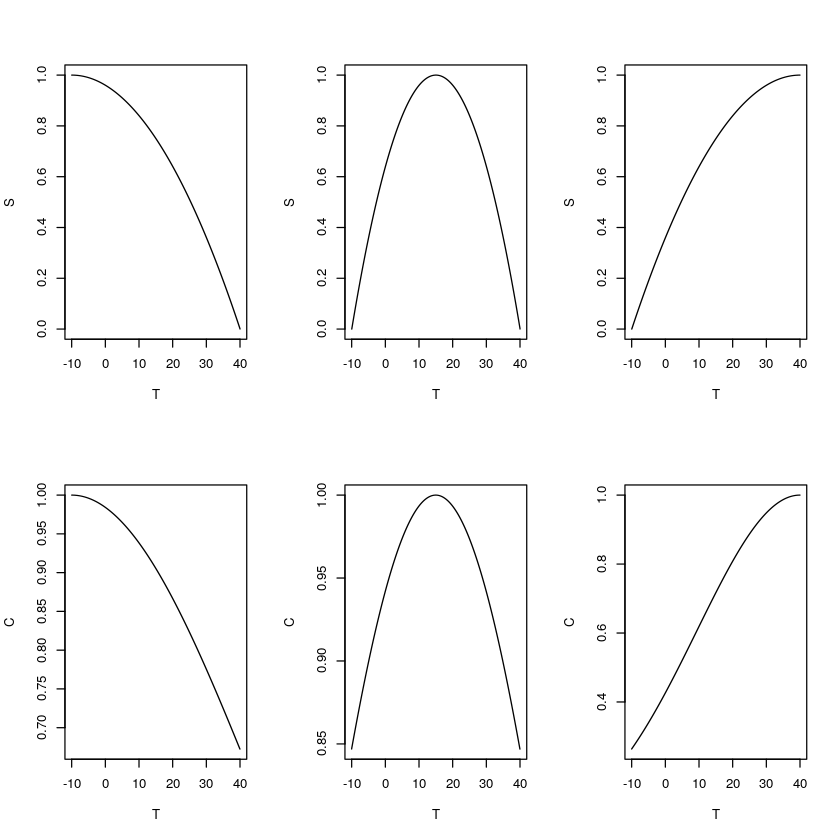

In [69]:
#plotting  S(T) and C(T) when the maximum is different

par(mfrow = c(2, 3))
Survival <- function(T, vertex, T_range, point) {
  eq <- make_quadratic_manually_scaled(vertex, point, T_range)
  return(eq[1] * T ^ 2 + eq[2] * T + eq[3])
}
plottingS <- function(maxvec, range) {
  T = seq(range[1], range[2] , length.out = 1000)
  for (i in maxvec) {
    temp_at_max <- i
    if (i > (range[2] - range[1]) / 2) {
      temp_at_min <- range[1]
    } else{
      temp_at_min <- range[2]
    }
    S = Survival(
      T = T,
      vertex = c(temp_at_max, 0),
      T_range = range,
      point = c(temp_at_min, -20)
    )
    plot(T, S, type = "s")
  }
}
plottingS(maxvec = c(-10, 15, 40), range = c(-10, 40))

S <- function(temp_at_max, range, T) {
  if (temp_at_max > (range[2] - range[1]) / 2) {
    temp_at_min <- range[1]
  } else{
    temp_at_min <- range[2]
  }
  return(Survival(
    T = T,
    vertex = c(temp_at_max, 0),
    T_range = range,
    point = c(temp_at_min, -20)
  ))
}

Contact <- function(T, m, c, T_range) {
  eq <- duration_scaled_1(m, c, T_range)
  #need to work on c means, if c=T here then doesn't work because not enough density???
  return(exp((-(T - eq[1]) ^ 2) / (2 * eq[2] ^ 2)))
}

#(m = c(40,maxcont/24) , c=c(-100,100), T_range=c(-10,40)
plottingC <- function(maxvec, range) {
  T = seq(range[1], range[2] , length.out = 1000)
  for (i in maxvec) {
    C = Contact(
      T = T,
      m = c(i, maxcont / 24),
      c = c(-100, 100),
      T_range = range
    )
    plot(T, C, type = "S")
  }
}

plottingC(maxvec = c(-10, 15, 40), range = c(-10, 40))

C <- function(temp_at_max, range, T) {
  return(Contact(
    T = T,
    m = c(temp_at_max, maxcont / 24),
    c = c(-10, 40),
    T_range = range
  ))
}


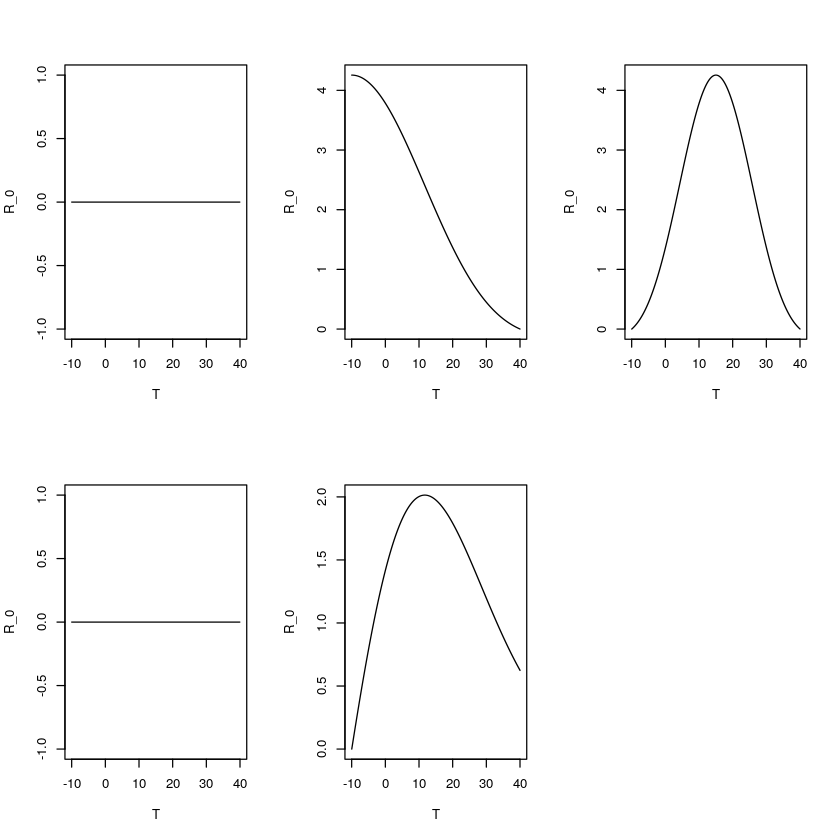

In [71]:
#plotting R0
par(mfrow = c(2, 3))
mu = 0
sigma = 0.25
alpha = 0.005
gamma = 0.23
beta_0 = 1

range = c(-10, 40)
T = seq(range[1], range[2] , length.out = 1000)
#completely susceptible population
#matching at high T
R_0 <-
  (sigma / (sigma + mu)) * (
    beta_0 * C(
      T = T,
      range = range,
      temp_at_max = range[2]
    ) * S(
      T = T,
      range = range,
      temp_at_max = range[2]
    ) / (mu + alpha + gamma)
  )
plot(T, R_0, type = "s")
#matching at low T
R_0 <-
  (sigma / (sigma + mu)) * (
    beta_0 * C(
      T = T,
      range = range,
      temp_at_max = range[1]
    ) * S(
      T = T,
      range = range,
      temp_at_max = range[1]
    ) / (mu + alpha + gamma)
  )
plot(T, R_0, type = "s")
#matching mid T
R_0 <-
  (sigma / (sigma + mu)) * (
    beta_0 * C(
      T = T,
      range = range,
      temp_at_max = range[1] + ((range[2] - range[1]) / 2)
    ) * S(
      T = T,
      range = range,
      temp_at_max = range[1] + ((range[2] - range[1]) / 2)
    ) / (mu + alpha + gamma)
  )
plot(T, R_0, type = "s")

#mismatch, S peaks at low T, C peaks at high T
R_0 <-
  (sigma / (sigma + mu)) * (
    beta_0 * C(
      T = T,
      range = range,
      temp_at_max = range[2]
    ) * S(
      T = T,
      range = range,
      temp_at_max = range[1]
    ) / (mu + alpha + gamma)
  )
plot(T, R_0, type = "s")
#mismatch, S peaks at high T, C peaks at low T
R_0 <-
  (sigma / (sigma + mu)) * (
    beta_0 * C(
      T = T,
      range = range,
      temp_at_max = range[1]
    ) * S(
      T = T,
      range = range,
      temp_at_max = range[2]
    ) / (mu + alpha + gamma)
  )
plot(T, R_0, type = "s")
#plotting  S(T) and C(T) when the maximum is different


In [32]:
require("epimdr")

Loading required package: epimdr
Loading required package: shiny
Loading required package: deSolve
Loading required package: polspline


## Thoughts

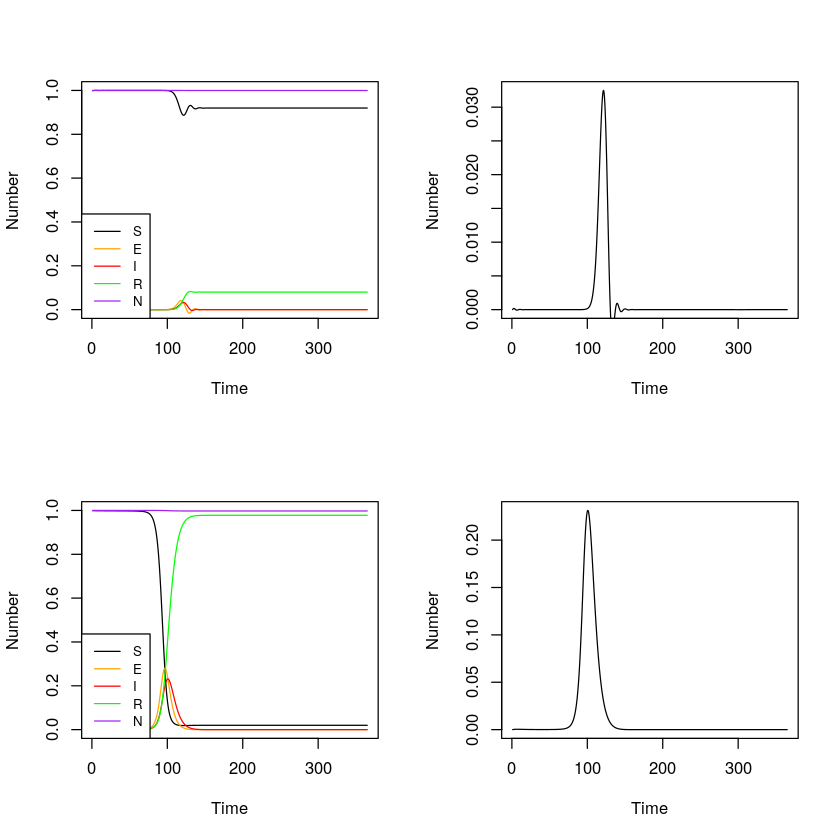

In [62]:
#plotting time 
T<- function(time) {
  # here, T is varying with time at a yearly cycle.
  return(25 * cos(2 * pi / 365 * time - pi) + 15)
}
#time=seq(0,1000,length.out = 1000)
#plot(time,T(time),type="s")


model <- function(time, values, parms) {
  #function where c changes with the climate and humidity at each timepoint
  #initial values
  S <- values[1]
  E <- values[2]
  I <- values[3]
  R <- values[4]
  #parameters
  mu <- parms[["mu"]]
  sigma <- parms[["sigma"]]
  alpha <- parms[["alpha"]]
  gamma <- parms[["gamma"]]
  beta0 <- parms[["beta0"]]
  range <-parms[["range"]]
  #temp and humidity are vectors in this model
  nu <- parms[["nu"]]
  N <- parms[["N"]]
  mismatch <- parms[["mismatch"]]
  #model
  T <- Temp(time,range[1],range[2])
  if (mismatch==1){
         beta<-beta0 * C(T = T, range = range, temp_at_max = range[2]) * S (T = T,range = range,temp_at_max = range[1])
  }else{
         midrange<-range[1] + ((range[2] - range[1]) / 2)
         beta<-beta0 * C(T = T, range = range, temp_at_max = midrange) * S (T = T,range = range,temp_at_max = midrange)
  }
  #seir model with varying beta values
  dS = nu * N - beta * I * S / N - mu * S 
  dE = beta * S * I / N - (sigma + mu) * E
  dI = sigma * E - (alpha + mu + gamma) * I
  dR = gamma * I - mu * R 
    
  list(c(dS, dE, dI, dR))
}

Temp<- function(time,min,max) {
  # here, T is varying with time at a yearly cycle.
  return((max-min) * cos(2 * pi / 365 * time - pi) + (max+min)/2)
}

plottime <- function(start, time, model, parms) {
  out = ode(
    y = start,
    time = time,
    func = model,
    parms = parms
  )
  Nvec<-out[, "S"] + out[, "E"] + out[, "I"] + out[, "R"]
  out<-cbind( out, Nvec)
  plot(x = out[, "time"],   y= out[, "S"],    ylab = "Number",   xlab = "Time",    type = "l",   xlim=c(min(time), max(time)),  ylim=c(0, parms[["N"]])
  )
  lines(x = out[, "time"],y= out[, "E"], col = "orange")
  lines(x = out[, "time"],y= out[, "I"], col = "red")
  lines(x = out[, "time"],y= out[, "R"], col = "green")
  lines(x = out[, "time"],y= out[, "Nvec"], col = "purple")  
      legend( "bottomleft",legend = c("S", "E", "I", "R","N"), col = c("black", "orange", "red", "green","purple"),lty = 1,    cex = 0.8
  )
}


plot_i_time <- function(start, time, model, parms) {
  out = ode(
    y = start,
    time = time,
    func = model,
    parms = parms
  )
  #Nvec<-out[, "S"] + out[, "E"] + out[, "I"] + out[, "R"]
  #out<-cbind( out, Nvec)
  plot(x = out[, "time"],   y= out[, "I"],    ylab = "Number",   xlab = "Time",    type = "l",   xlim=c(min(time), max(time)),  ylim=c(0, max(out[,"I"]))
  )
  #lines(x = out[, "time"],y= out[, "E"], col = "orange")
 # lines(x = out[, "time"],y= out[, "I"], col = "red")
 # lines(x = out[, "time"],y= out[, "R"], col = "green")
  #lines(x = out[, "time"],y= out[, "Nvec"], col = "purple")  
 #     legend( "bottomleft",legend = c("S", "E", "I", "R","N"), col = c("black", "orange", "red", "green","purple"),lty = 1,    cex = 0.8
}




time = seq(1, 365, by = 0.01)
#parameters from bjornstad book and guesses- just to test functions work! not sure if this is quite right
start = c(S = 0.999*parms[["N"]],
          E = 0.001*parms[["N"]],
          I = 0.00*parms[["N"]],
          R = 0*parms[["N"]])

parms = list(
  mu = 00.000,
  sigma = 0.2 ,
  alpha = 0.0005,
  beta0 = 2,
  gamma =0.2,
  N = 1,
  nu = 0.0,
  range = c(-10,40),
  mismatch=0
)

par(mfrow = c(2, 2))

plottime(
  time = time,
  parms = parms,
  start = start,
  model = model
)

plot_i_time(time = time,
  parms = parms,
  start = start,
  model = model)

parms = list(
  mu = 00.000,
  sigma = 0.2 ,
  alpha = 0.0005,
  beta0 = 2,
  gamma =0.2,
  N = 1,
  nu = 0.0,
  range = c(-10,40),
  mismatch=1
)
plottime(
  time = time,
  parms = parms,
  start = start,
  model = model
)

plot_i_time(
  time = time,
  parms = parms,
  start = start,
  model = model
)

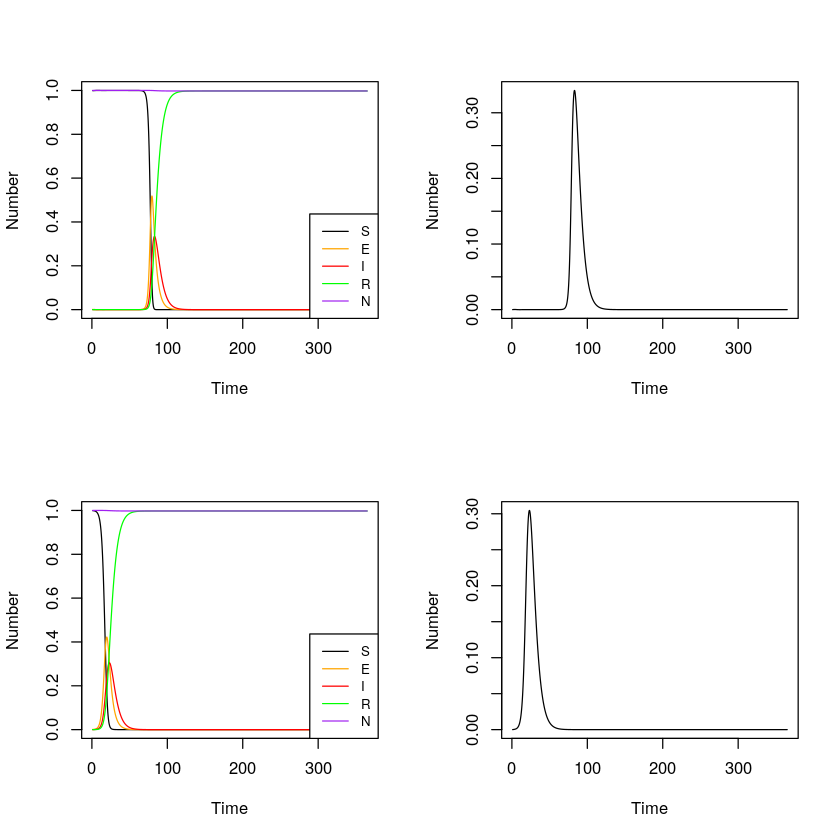

In [68]:
#plotting time 
T<- function(time) {
  # here, T is varying with time at a yearly cycle.
  return(25 * cos(2 * pi / 365 * time - pi) + 15)
}
#time=seq(0,1000,length.out = 1000)
#plot(time,T(time),type="s")


model <- function(time, values, parms) {
  #function where c changes with the climate and humidity at each timepoint
  #initial values
  S <- values[1]
  E <- values[2]
  I <- values[3]
  R <- values[4]
  #parameters
  mu <- parms[["mu"]]
  sigma <- parms[["sigma"]]
  alpha <- parms[["alpha"]]
  gamma <- parms[["gamma"]]
  beta0 <- parms[["beta0"]]
  range <-parms[["range"]]
  #temp and humidity are vectors in this model
  nu <- parms[["nu"]]
  N <- parms[["N"]]
  mismatch <- parms[["mismatch"]]
  #model
  T <- Temp(time,range[1],range[2])
  if (mismatch==1){
         beta<-beta0 * (1 + C(T = T, range = range, temp_at_max = range[2]) * S (T = T,range = range,temp_at_max = range[1]))
  }else{
         midrange<-range[1] + ((range[2] - range[1]) / 2)
         beta<-beta0 * (1 +  C(T = T, range = range, temp_at_max = midrange) * S (T = T,range = range,temp_at_max = midrange))

  }
  #seir model with varying beta values
  dS = nu * N - beta * I * S / N - mu * S 
  dE = beta * S * I / N - (sigma + mu) * E
  dI = sigma * E - (alpha + mu + gamma) * I
  dR = gamma * I - mu * R 
    
  list(c(dS, dE, dI, dR))
}

Temp<- function(time,min,max) {
  # here, T is varying with time at a yearly cycle.
  return((max-min) * cos(2 * pi / 365 * time - pi) + (max+min)/2)
}

plottime <- function(start, time, model, parms) {
  out = ode(
    y = start,
    time = time,
    func = model,
    parms = parms
  )
  Nvec<-out[, "S"] + out[, "E"] + out[, "I"] + out[, "R"]
  out<-cbind( out, Nvec)
  plot(x = out[, "time"],   y= out[, "S"],    ylab = "Number",   xlab = "Time",    type = "l",   xlim=c(min(time), max(time)),  ylim=c(0, parms[["N"]])
  )
  lines(x = out[, "time"],y= out[, "E"], col = "orange")
  lines(x = out[, "time"],y= out[, "I"], col = "red")
  lines(x = out[, "time"],y= out[, "R"], col = "green")
  lines(x = out[, "time"],y= out[, "Nvec"], col = "purple")  
      legend( "bottomright",legend = c("S", "E", "I", "R","N"), col = c("black", "orange", "red", "green","purple"),lty = 1,    cex = 0.8
  )
}


plot_i_time <- function(start, time, model, parms) {
  out = ode(
    y = start,
    time = time,
    func = model,
    parms = parms
  )
  #Nvec<-out[, "S"] + out[, "E"] + out[, "I"] + out[, "R"]
  #out<-cbind( out, Nvec)
  plot(x = out[, "time"],   y= out[, "I"],    ylab = "Number",   xlab = "Time",    type = "l",   xlim=c(min(time), max(time)),  ylim=c(0, max(out[,"I"]))
  )
  #lines(x = out[, "time"],y= out[, "E"], col = "orange")
 # lines(x = out[, "time"],y= out[, "I"], col = "red")
 # lines(x = out[, "time"],y= out[, "R"], col = "green")
  #lines(x = out[, "time"],y= out[, "Nvec"], col = "purple")  
 #     legend( "bottomleft",legend = c("S", "E", "I", "R","N"), col = c("black", "orange", "red", "green","purple"),lty = 1,    cex = 0.8
}




time = seq(1, 365, by = 0.1)
#parameters from bjornstad book and guesses- just to test functions work! not sure if this is quite right
start = c(S = 0.999*parms[["N"]],
          E = 0.001*parms[["N"]],
          I = 0.00*parms[["N"]],
          R = 0*parms[["N"]])

parms = list(
  mu = 00.000,
  sigma = 0.2 ,
  alpha = 0.0005,
  beta0 = 2,
  gamma =0.2,
  N = 1,
  nu = 0.0,
  range = c(-10,40),
  mismatch=0
)

par(mfrow = c(2, 2))

plottime(
  time = time,
  parms = parms,
  start = start,
  model = model
)

plot_i_time(time = time,
  parms = parms,
  start = start,
  model = model)

parms = list(
  mu = 00.000,
  sigma = 0.2 ,
  alpha = 0.0005,
  beta0 = 2,
  gamma =0.2,
  N = 1,
  nu = 0.0,
  range = c(-10,40),
  mismatch=1
)
plottime(
  time = time,
  parms = parms,
  start = start,
  model = model
)

plot_i_time(
  time = time,
  parms = parms,
  start = start,
  model = model
)

include humidity-look into absolute humidity. claim from guinea pigs paper  
lag period?  
idea of model fitting to data using ABC- maybe for influenza  
currently worried about all the possible causes of seasonality that I'm not including! - immunity with climate, droplet size with humidity


for both S and C need to make a decision about scaling- (0-1 or more meaningful)
0-1 --> then will be dimensionless
meaningful -->units cancel but how do we make sure similar effect. (to scale this could / by max(C)* max(S)

## Parameter table

|Parameter|Meaning|Unit|Origin|
|------|------|------|------|
|$\alpha$     |rate of disease induced mortality (per capita?)   |unit time$^{-1}$  |Bjørnstad 2018|
|$\beta$     |transmission rate per infective    | unit time$^{-1}$   |Keeling and Rohani 2007|
|$\beta_0$     |average annual infection rate|unit time$^{-1}$      |Neher 2020|
|$\gamma$     |recovery rate - probably of recovery for an individual per unit time (reciprocal of infectious period)   |unit time$^{-1}$  |Keeling and Rohani 2007|
|$\mu$    |natural per capita death rate -not caused by disease|unit time$^{-1}$    |Keeling and Rohani 2007|
|$\nu$    |natural per capita birth rate |unit time$^{-1}$  |Keeling and Rohani 2007|
|$\sigma$     |rate of movement from E to I (reciprocal of latent period)|unit time$^{-1}$  Keeling and Rohani 2007|
|$S$     |number of susceptibles    |  n |Keeling and Rohani 2007|
|$E$     |number of exposed |  n   |Keeling and Rohani 2007|
|$I$     |number of infected     |  n |Keeling and Rohani 2007|
|$R$     |number of recovered    | n  |Keeling and Rohani 2007|
|$N$     |number of individauls   | n  |Keeling and Rohani 2007|
|$T$  |temperature |degrees c|-|
|$RH$   |relative humidity|%|-|
|$m$ |containment parameter|-|Neher 2020|
|$k$   |inflection point of Hill function||Neher 2020|
|$\epsilon$   |amplitude of seasonal forcing||Neher 2020|
|$\theta$  |time of peak transmissability||Neher 2020|
|$S$  |survival rate |$time^{-1}$|-|
|$C$  |Contact parameter|unit time|-|
|$H$  |dimensionless hill function- containment |-|Neher 2020|
|$d$  |average contact duration|unit time|-|
|$s$  |Standard distribution of normal distribution|-|-|
|$N_D$  |normal distribution|-|-|
|$m_T$,$m_d$ |Temperature and duration at maximum duration |degrees C, unit time|-|
|$c_l$,$c_u$|lower, upper interval at which 95\%  of the duration is likely to occur |-|-|
|$q$   |viral rate of decay|$time^{-1}$||
|$V$   |viral titre/amount |not sure yet (but cancels)||
|$V_0$   |initial viral titre/amount |not sure yet (but cancels)||
|$f(T)$   |quadratic function for S |time$^-1$||



kappa not used in these models but :|$\kappa$   |average number of contacts per individual per unit time|$year^-1$ |Keeling and Rohani 2007||$m_T$,$m_d$ |Temperature and duration at midpoint duration |degrees C, unit time|-|
|$p_T$,$p_d$  |Temperature and duration at a point|degrees C, unit time|-|

units calculated from:  
units of de/dt,ds/st,di/dt, dr/dt$N\times$unit time$^{-1}$ 


## Not in use 

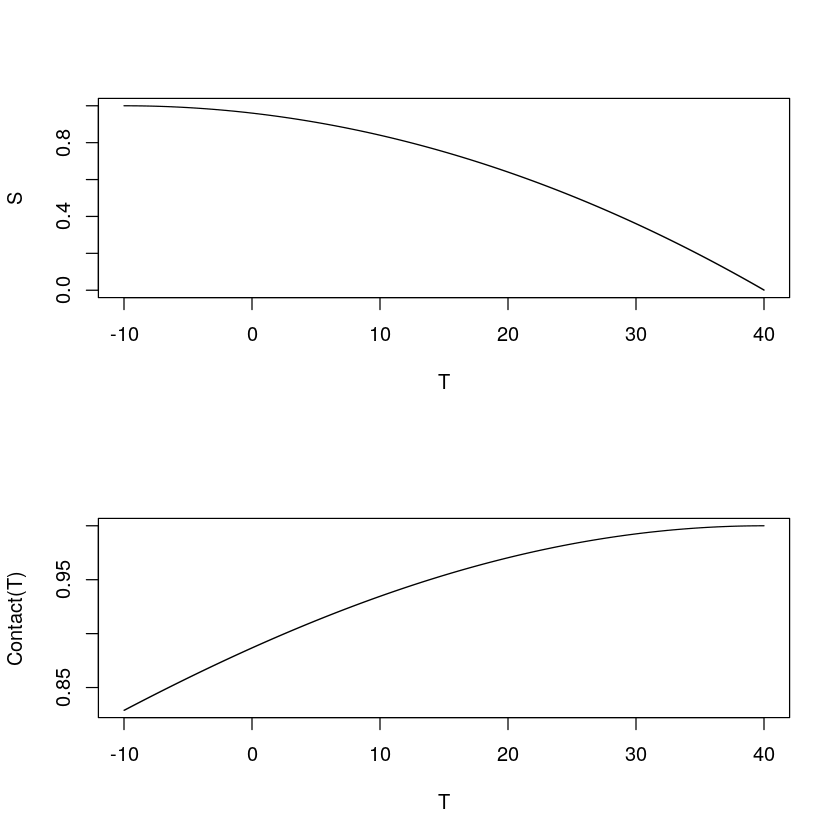

In [63]:
#for maximum mismatch
par(mfrow = c(2, 1))
Survival<-function(T){
    eq<-make_quadratic_manually_scaled(vertex=c(-10,0),T_range=c(-10,40),point=c(40,-20))
    return(eq[1]*T^2+eq[2]*T+eq[3])
}
T = seq(-10,40 , length.out = 1000)
S = Survival(T = seq(-10, 40 , length.out = 1000))
plot(T,S,type="s")

 
Contact<-function(T){
    eq<-duration_scaled_1(m = c(40,maxcont/24) , c=c(-200,200), T_range=c(-10,40))
 #need to work on c means, if c=T here then doesn't work because not enough density???   
    return(exp( ( - ( T - eq[1] ) ^2 ) / (2 * eq[2]^2)))
}
T = seq(-10,40 , length.out = 1000)

plot(T,Contact(T),type="s")

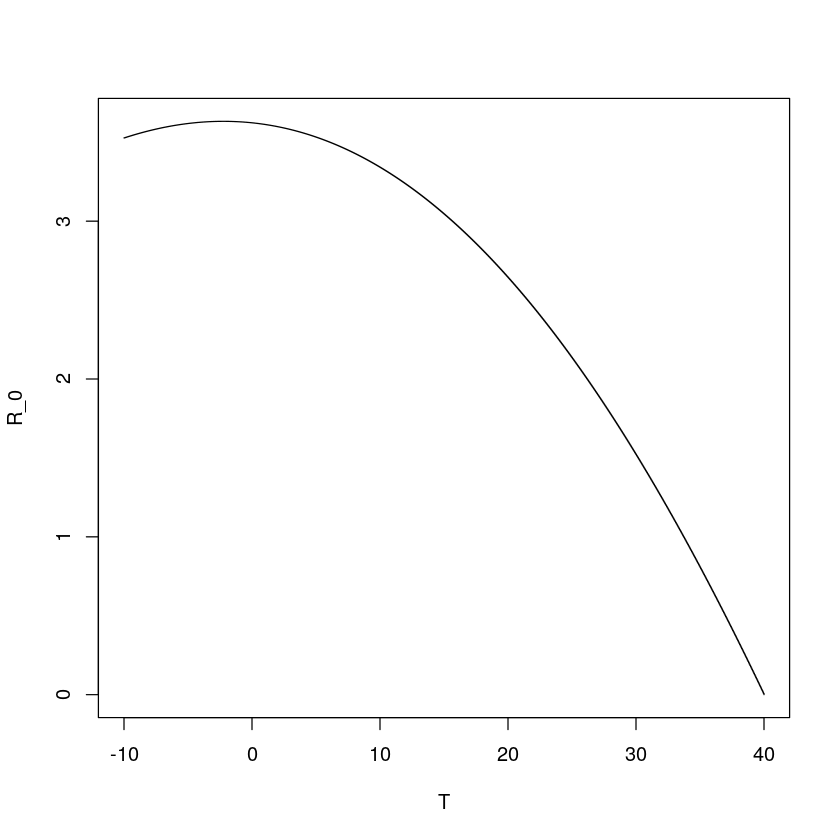

In [64]:
mu = 0
sigma = 0.25 
alpha = 0.005
gamma = 0.23
beta_0 = 1 
T = seq(-10,40 , length.out = 1000)
#C = C(T)
#plot(T,C,type="s")

T = seq(-10,40 , length.out = 1000)
C=Contact(T)
S=Survival(T)
R_0<-(sigma/(sigma+mu))*((beta_0*C*S)/(mu+alpha+gamma))
plot(T,R_0,type="s")